In [1]:
import h5py
import numpy as np
import seaborn as sns

from src.data.loaders import aisy
from src.data.preprocess.hw import full_states, hamming_weights
from src.dlla.hw import prepare_traces_dl, dlla_known_p
from src.dlla.berg import make_mlp
from src.tools.cache import cache_np
from src.tools.lists import find
from src.tools.plotter import init_plots
from src.trace_set.database import Database
from src.trace_set.set_hw import TraceSetHW
from src.tvla.cri import rho_test

init_plots()

In [2]:
TRACES = cache_np("aisy_traces")

IN_FILE = h5py.File(aisy.aes.tvla, "r")
# TRACES = np.array(IN_FILE['traces_group/traces'], dtype=np.int8)
TVLA_BYTE = IN_FILE['traces_group/metadata']['tvla_byte'].astype(bool)[:, 0]

PLAINTEXT = IN_FILE['traces_group/metadata']['plaintext'].astype(int)
CIPHERTEXT = IN_FILE['traces_group/metadata']['ciphertext'].astype(int)

KEY = IN_FILE['traces_group/metadata']['key'].astype(int)

In [3]:
PVS = rho_test(TRACES, TVLA_BYTE)

Computing Correlation Coefficients: 100%|██████████| 220000/220000 [00:52<00:00, 4212.72it/s]


In [4]:
np.min(PVS[0])

0.0

[None]

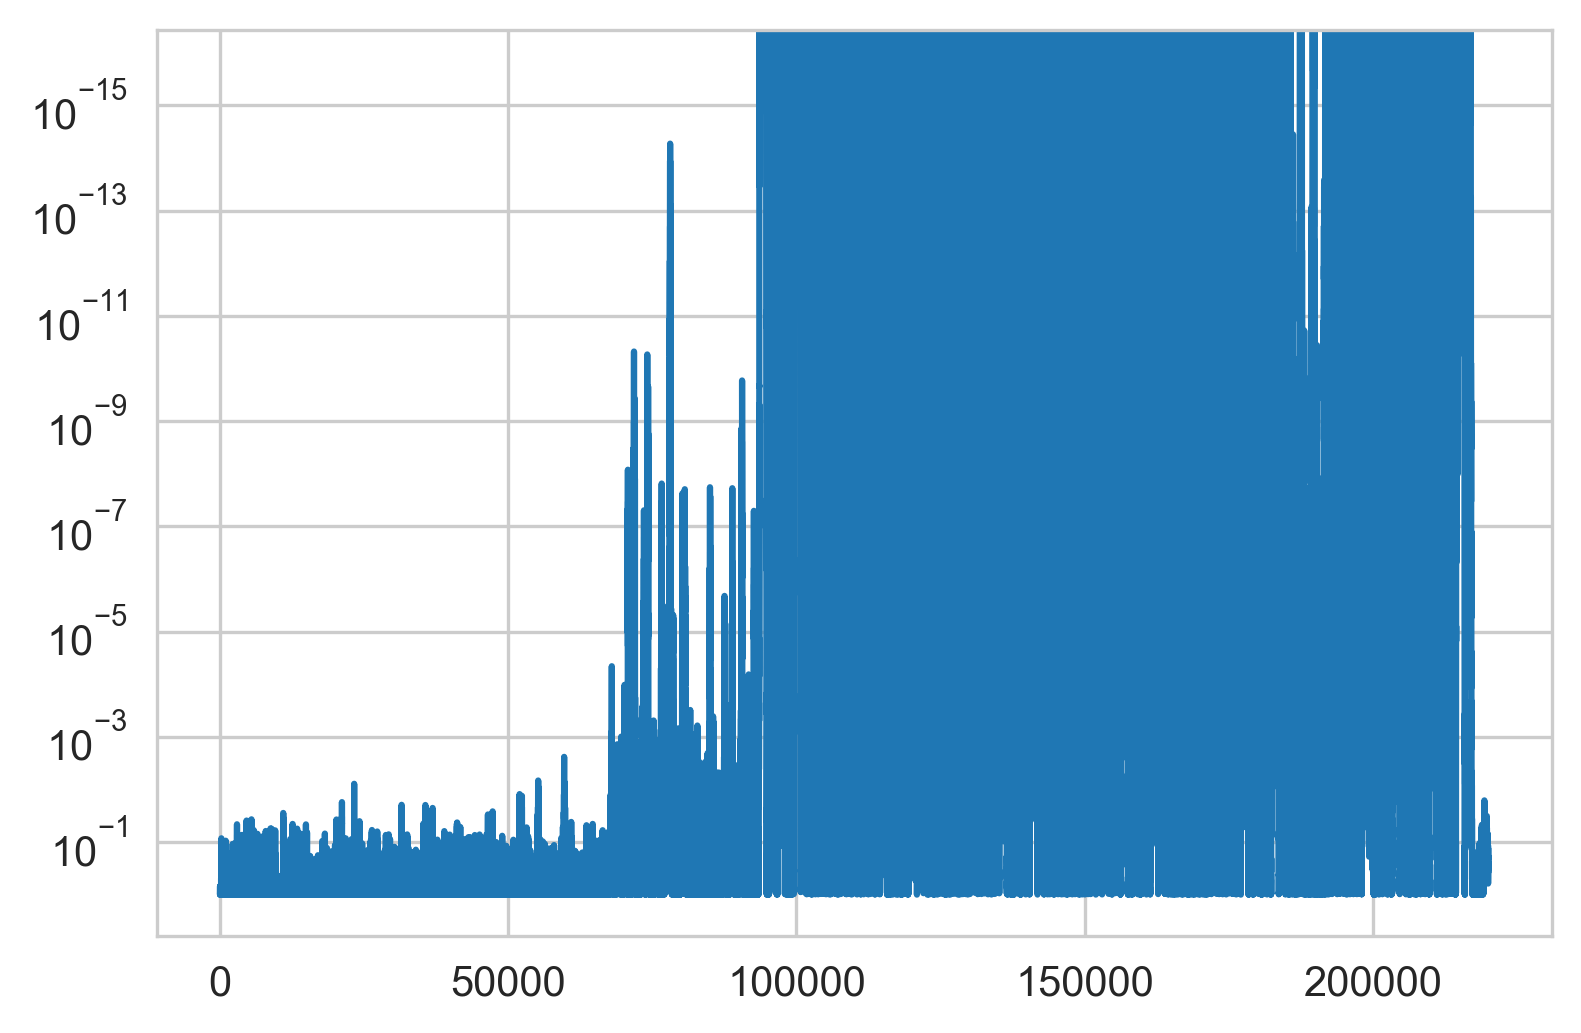

In [5]:
G = sns.lineplot(data=PVS[0])
G.invert_yaxis()
G.set(yscale="log")

[None, (93000.0, 95000.0)]

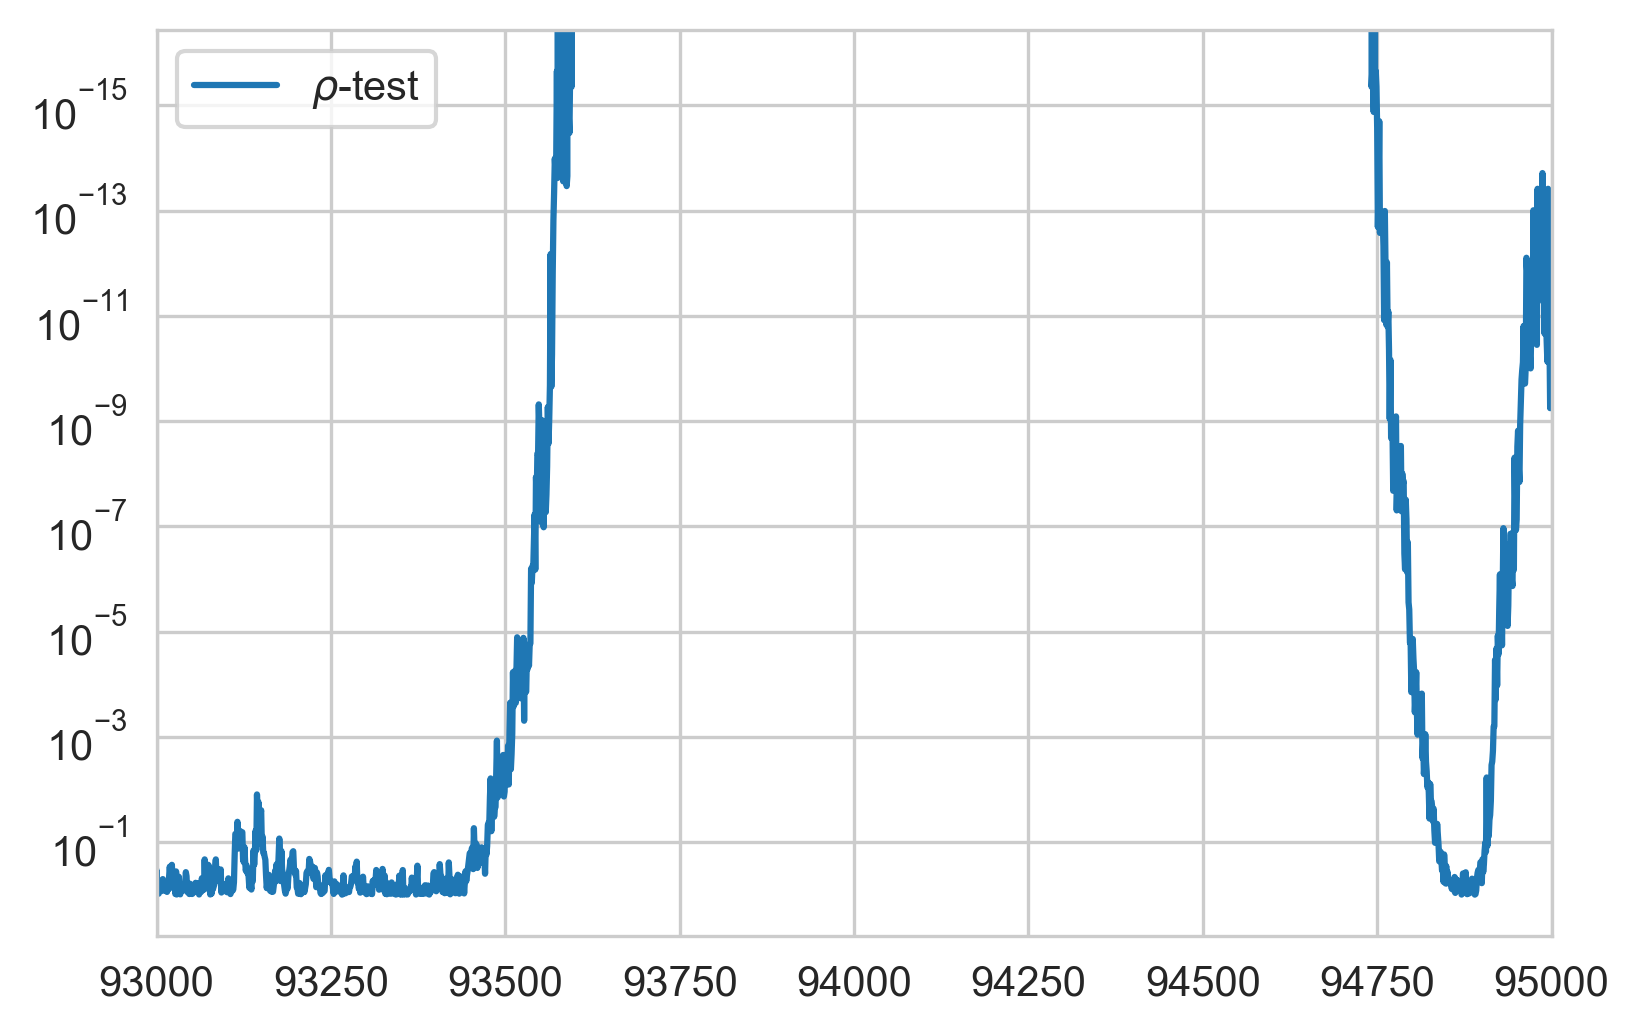

In [6]:
START, END = 93000, 95000

G = sns.lineplot(data={"$\\rho$-test": PVS[0]})
G.invert_yaxis()
G.set(yscale="log", xlim=(START, END))

In [7]:
STATES = full_states(PLAINTEXT, KEY)

100%|██████████| 10000/10000 [00:02<00:00, 3684.27it/s]


In [8]:
TARGET_ROUND = 4 # Fifth round
TARGET_BIT = 0

TARGET_STATE = STATES[:, TARGET_ROUND, TARGET_BIT]

In [9]:
POI_TRACES = TRACES[:, START:END]

In [10]:
PROFILING_MASK = np.ones(len(POI_TRACES), dtype=bool)
PROFILING_MASK[2::3] = 0

X, Y = POI_TRACES[PROFILING_MASK], TARGET_STATE[PROFILING_MASK]
X_ATT, Y_ATT = POI_TRACES[~PROFILING_MASK], TARGET_STATE[~PROFILING_MASK]

TraceSetHW(Database.aisy).create(X, Y, X_ATT, Y_ATT)

In [11]:
TRACE_SET = TraceSetHW(Database.aisy)
X9, Y9, X9_ATT, Y9_ATT = prepare_traces_dl(*TRACE_SET.profile(), *TRACE_SET.attack())
MDL9 = make_mlp(X9, Y9)
DLLA9_P = dlla_known_p(MDL9, X9_ATT, Y9_ATT)

DLLA9_P

Epoch 1/5


InternalError:  Blas xGEMM launch failed : a.shape=[1,200,2000], b.shape=[1,2000,200], m=200, n=200, k=2000
	 [[node sequential/dense/MatMul (defined at /home/berg/Documents/Afstudeer/LA/src/dlla/berg.py:22) ]] [Op:__inference_train_function_888]

Function call stack:
train_function
